In [1]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import h5py

sns.set_style('whitegrid')

sns.set_context('notebook')

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
%load_ext autoreload
%autoreload 2

root = '/home/ubuntu/ext_vol'
import sys
sys.path.insert(0, f'{root}/inpca')

from utils import get_data, get_idx, triplot, plotly_3d, load_d, dinpca, dbhat, plotly_3d
from utils.embed import proj_, lazy_embed
from reparameterization import v0

In [2]:
import plotly.graph_objects as go
import numpy as np
import plotly.offline as pyo
import pandas as pd
pyo.init_notebook_mode()
from matplotlib.lines import Line2D    
from utils import CDICT_M

In [3]:
dev='cuda'

## Four pts avg

### AllCNN

In [14]:
lam1 = 0.3
lam2 = 1-lam1
r = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/r_tangent_allcnn_{lam1}-{lam2}-0-0.p')
didx = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/didx_allcnn_{lam1}-{lam2}-0-0.p')

In [15]:
all_points = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/all_points_allcnn_{lam1}-{lam2}-0-0.p')

In [16]:
t0 = all_points[2, :] - all_points[0, :]
ts = all_points[1, :] - all_points[3, :]

In [17]:
(ts*t0).sum()/(np.linalg.norm(t0)*np.linalg.norm(ts))

tensor(0.1297, dtype=torch.float64)

In [18]:
dpts = pd.DataFrame(['p0', 'ps', 'init', 'end'], columns=['opt'])
didx = pd.concat([dpts, didx])

In [19]:
rtrue = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/rtrue_allcnn_{lam1}-{lam2}-0-0.p')

In [20]:
cdict = {o:'#e41a1c' for o in didx['opt'].unique()}

In [ ]:
emph={opt:[i] for (i, opt) in enumerate(didx.iloc[:4]['opt'])}
emphcolor={o:'black' for o in emph.keys()}
emphsize={o:8 for o in emph.keys()}

plotly_3d(didx, r, color='opt', 
          emph=emph,
          empcolor = emphcolor,
          empsize=emphsize,
          cols=['opt','t'], discrete_c=True, 
          cdict=cdict,
          opacity=1,color_axis=True)

In [21]:
rel_err = np.array(th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/rel_err_allcnn_{lam1}-{lam2}-0-0.p'))
df = []
ndims=4
dim_dict = {1: 'Space-like', -1: 'Time-like'}
for i in range(ndims):

    df.append({
        'name':'Original InPCA',
        'explained':1-rel_err[i, 1],
        'dim_name':dim_dict[np.sign(rtrue['e'][i])],
        'dim':i+1,
    })
    if i < 3:
        df.append({
        'name':f'InPCA onto three bases',
        'explained':1-rel_err[i, 0],
        'dim_name':dim_dict[np.sign(r['e'][i])],
        'dim':i+1
    }) 
df = pd.DataFrame(df)

In [22]:
df

name  explained    dim_name  dim
0          Original InPCA   0.817258  Space-like    1
1  InPCA onto three bases   0.784205  Space-like    1
2          Original InPCA   0.885639  Space-like    2
3  InPCA onto three bases   0.913440  Space-like    2
4          Original InPCA   0.896230  Space-like    3
5  InPCA onto three bases   0.924208  Space-like    3
6          Original InPCA   0.888424   Time-like    4

In [23]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1.5,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

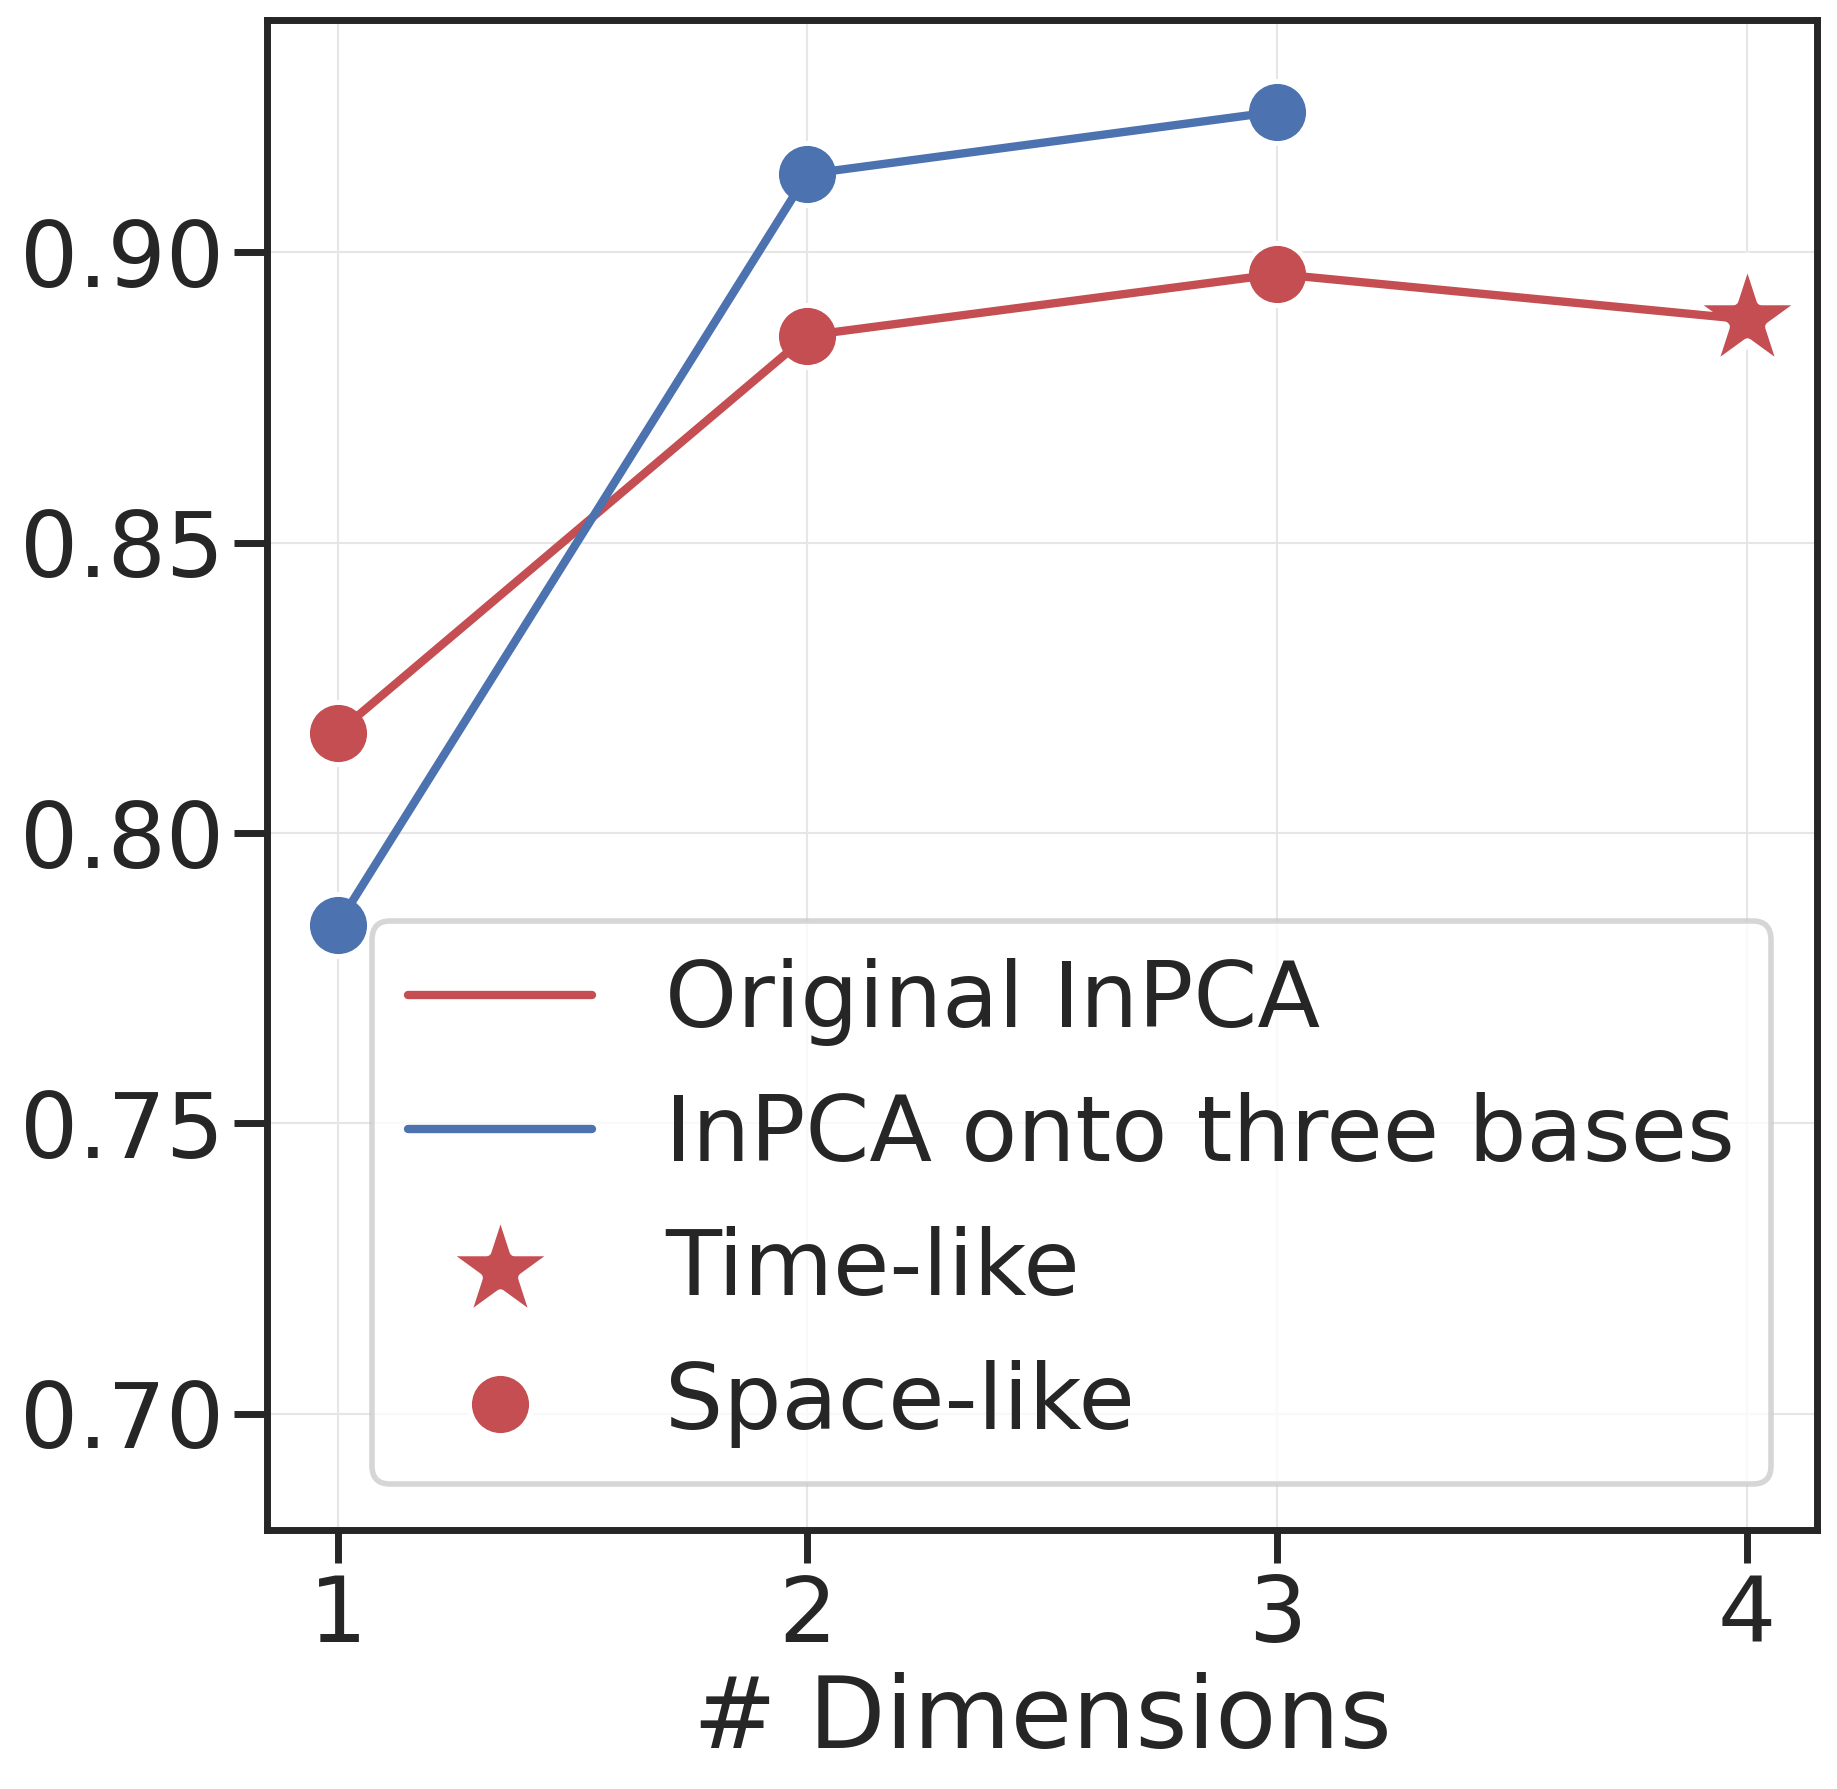

In [26]:
f, ax=plt.subplots()
palette = {'Original InPCA':'r', 'InPCA onto three bases':'b', }
sns.lineplot(data=df, x='dim', y='explained', hue='name', palette=palette)
for v in palette.keys():
    for dim_name in ['Time-like','Space-like']:
        marker = '*' if dim_name=='Time-like' else 'o'
        s = 2000 if dim_name == 'Time-like' else 500
        sns.scatterplot(data=df[(df.name==v) & (df.dim_name == dim_name)], 
                        s=s, color=palette[v],
                        x='dim', y='explained', label=dim_name, ax=ax, marker=marker)
ax.set(ylabel='', xlabel='# Dimensions', ylim=[0.68, 0.94])
handles, labels = ax.get_legend_handles_labels()
# plt.legend()
ax.legend(handles=handles[:-1], labels=labels[:-1], fontsize=12)
ax.legend_.set_title(None)
sns.move_legend(ax, "lower right")

In [27]:
plot_root = '/home/ubuntu/ext_vol/6217ef20ae4596301f213f84/fig'
f.savefig(f'{plot_root}/allcnn_new_inpca_pairwise_distances.pdf', bbox_inches='tight')

## All Models

In [4]:
fn = 'four_pts_avg'
r = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/r_tangent_four_pts_avg_0.2_0.8_0_0.p')
d = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_no_outliers.p')

In [5]:
rtrue = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_no_outliers.p')

In [6]:
ii = np.argsort(np.abs(rtrue['es']))[::-1]
es = rtrue['es'][ii]

In [7]:
rel_err = []
ndims=8
errtan = np.array(th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/rel_err_four_pts_avg_0.2_0.8_0_0.p'))[:, 0]
errtrue = np.array(th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/rel_err_no_outliers.p'))[:ndims, 0]             
dim_dict = {1: 'Space-like', -1: 'Time-like'}
for i in range(ndims):
    rel_err.append({
        'name':'Original InPCA',
        'explained':1-errtrue[i],
        'dim_name':dim_dict[np.sign(es[i])],
        'dim':i+1,
    })
    if i < 3:
        rel_err.append({
        'name':'InPCA onto three bases',
        'explained':1-errtan[i],
        'dim_name':dim_dict[np.sign(r['e'][i])],
        'dim':i+1
    }) 

In [8]:
rel_err = pd.DataFrame(rel_err)

In [11]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1.5,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

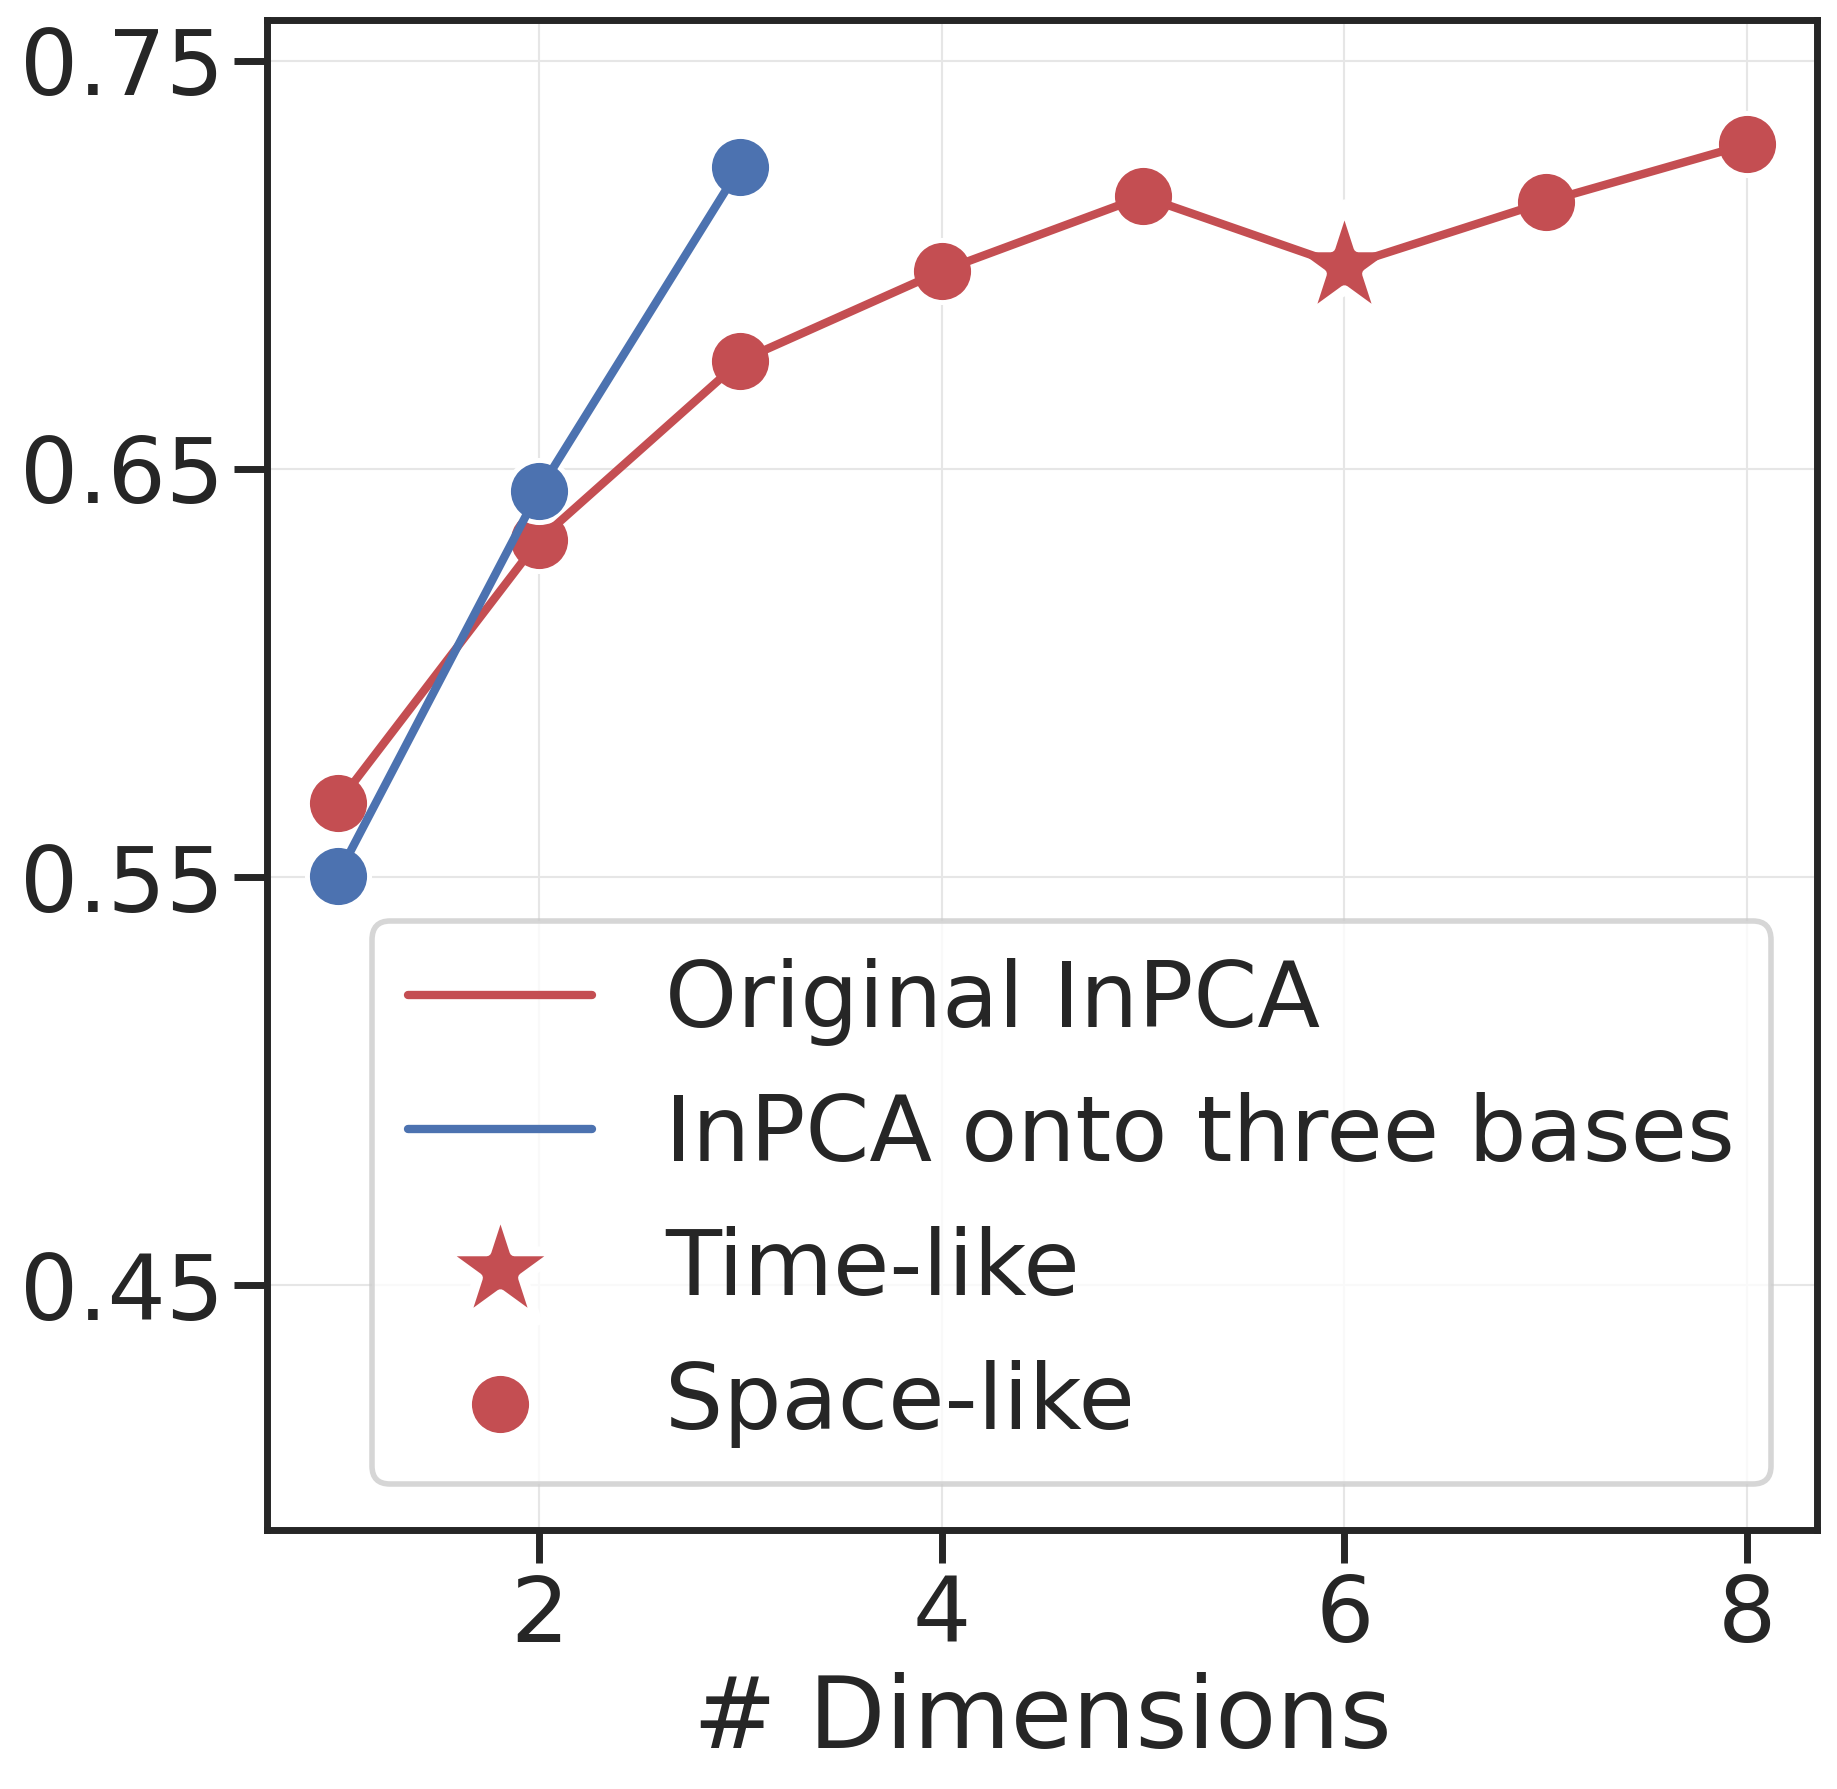

In [21]:
f, ax=plt.subplots()
palette = {'Original InPCA':'r', 'InPCA onto three bases':'b', }
sns.lineplot(data=rel_err, x='dim', y='explained', hue='name', palette=palette)
for v in palette.keys():
    for dim_name in ['Time-like','Space-like']:
        marker = '*' if dim_name=='Time-like' else 'o'
        s = 2000 if dim_name == 'Time-like' else 500
        sns.scatterplot(data=rel_err[(rel_err.name==v) & (rel_err.dim_name == dim_name)], 
                        s=s, color=palette[v],
                        x='dim', y='explained', label=dim_name, ax=ax, marker=marker)
ax.set(ylabel='', xlabel='# Dimensions', ylim=[0.39, 0.76], yticks=np.arange(4, 8)*0.1+0.05)
handles, labels = ax.get_legend_handles_labels()
# plt.legend()
ax.legend(handles=handles[:-1], labels=labels[:-1], fontsize=12)
ax.legend_.set_title(None)
sns.move_legend(ax, "lower right")

In [22]:
plot_root = '/home/ubuntu/ext_vol/6217ef20ae4596301f213f84/fig'
f.savefig(f'{plot_root}/all_models_new_inpca_pairwise_distances.pdf', bbox_inches='tight')

In [163]:
th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/rel_err_four_pts_avg_0.2_0.8_50_50.p')

[[0.4645041159214666],
 [0.37618108617943335],
 [0.33917239406144567],
 [0.395715927914087]]

In [44]:
# r = th.load('/home/ubuntu/ext_vol/inpca/r_tangent_all_tangents.p')
pts1 = th.load('/home/ubuntu/ext_vol/inpca/all_points_tangent_four_pts_avg.p')
pts2 = th.load('/home/ubuntu/ext_vol/inpca/all_points_tangent_four_pts_avg_0.1_0.9_0_0.p')

In [5]:
1-np.array(rel_err)

array([[0.53318457],
       [0.49543507],
       [0.61678328],
       [0.6287143 ],
       [0.60935042]])

## Four points avg

In [83]:
fig = go.Figure(data=[go.Scatter3d(x=r['xp'][:, 0], y=r['xp'][:, 1], z=r['xp'][:, 2],
                                   mode='markers')])
fig.show()

In [84]:
r = th.load(f'r_tangent_{fn}.p')
rtrue = th.load(f'rtrue_{fn}.p')

In [85]:
rel_err = []
for i in range(1, 5):
    dd = dinpca(th.tensor(r['xp'][-len(d):, :i]), 
                sign=th.tensor(np.sign(r['e'][:i])).double()).cpu().numpy()
    dtrue = dinpca(th.tensor(rtrue['xp'][-len(d):, :i]), 
                   sign=th.tensor(np.sign(rtrue['e'][:i])).double()).cpu().numpy()
    rel_err.append(dict(dim=i, explained_dist=1-(np.abs(dd.T - dists)).sum() / dists.sum(), 
                        true_explained_dist=1-(np.abs(dtrue.T - dists)).sum() / dists.sum()))


In [81]:
th.save(rel_err, f'rel_err_{fn}.p')
rel_err

[{'dim': 1,
  'explained_dist': 0.6314305706356351,
  'true_explained_dist': 0.6724295396783933},
 {'dim': 2,
  'explained_dist': 0.7328002767777959,
  'true_explained_dist': 0.7313811661215033},
 {'dim': 3,
  'explained_dist': 0.7721077916331066,
  'true_explained_dist': 0.7681195183187294},
 {'dim': 4,
  'explained_dist': 0.7721077916331069,
  'true_explained_dist': 0.7842275075571787}]

In [86]:
th.save(rel_err, f'rel_err_{fn}.p')
rel_err

[{'dim': 1,
  'explained_dist': 0.7851277666393713,
  'true_explained_dist': 0.8182055151030452},
 {'dim': 2,
  'explained_dist': 0.9144830924527784,
  'true_explained_dist': 0.8866780114441115},
 {'dim': 3,
  'explained_dist': 0.9247177053867726,
  'true_explained_dist': 0.8972690551446765},
 {'dim': 4,
  'explained_dist': 0.9247177053867726,
  'true_explained_dist': 0.8895144263851168}]

In [70]:
r = th.load(f'r_tangent_allcnn_four_pts_avg_0.3_0.7_0_0.p')
didx = th.load(
        '/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p')
    
didx = didx[(didx.m == 'allcnn') & (didx.bs == '200') & (didx.aug == 'none') & (
    didx.wd == '0.0') & (didx.lr != '0.001')].reset_index(drop=True)
dpts = pd.DataFrame(['p0', 'ps', 'init', 'end'], columns=['m'])
didx = pd.concat([dpts, didx])

<AxesSubplot:xlabel='dim', ylabel='value'>

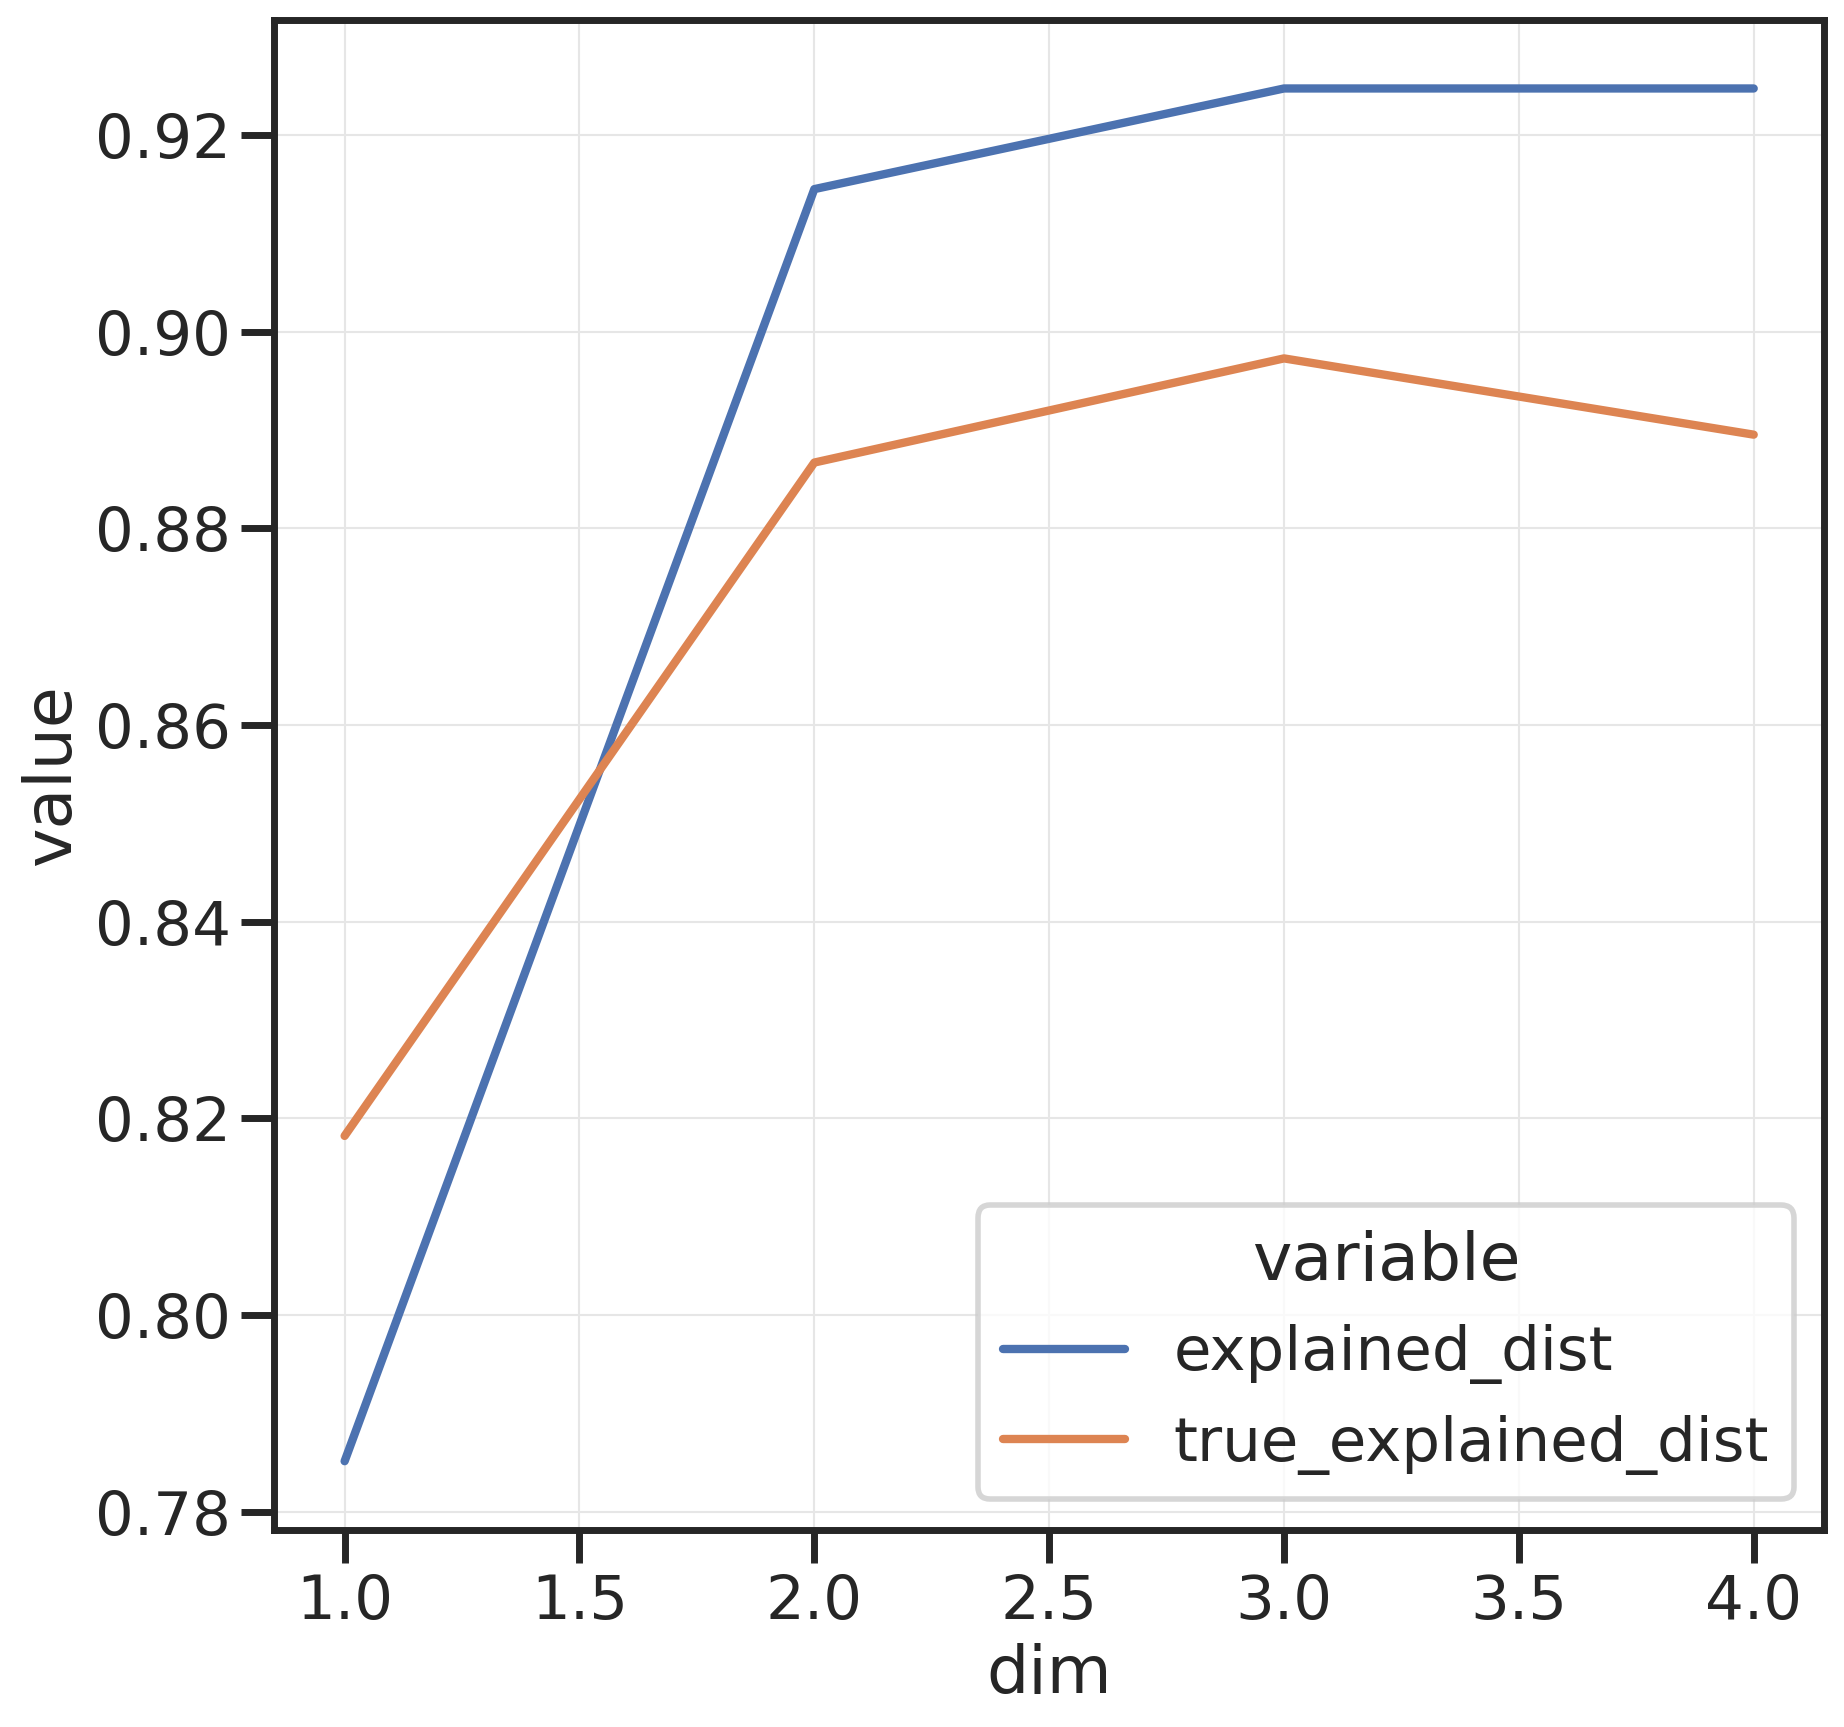

In [71]:
df = pd.DataFrame(th.load('/home/ubuntu/ext_vol/inpca/notebooks/rel_err_allcnn_four_pts_avg_0.3_0.7_0_0.p'))
df = df.melt(id_vars=['dim'],value_vars=['explained_dist', 'true_explained_dist'])
sns.lineplot(data=df, x='dim', y='value', hue='variable')

In [ ]:
plotly_3d(didx, r, color='opt', 
          cols=['opt','t'], discrete_c=True, 
#           cdict={'init': '#000000', 'geod': '#000000', 'end': '#000000', 
#                  'allcnn': '#e41a1c', 'convmixer': '#377eb8',
#                  'fc': '#4daf4a', 'vit': '#984ea3', 'wr-10-4-8': '#ff7f00', 
#                  'wr-16-4-64': '#ffff33'},
#           xrange=[-1.5,1], yrange=[-1.5,0.5], zrange=[-3, 0.5],
          opacity=1,color_axis=True)

In [35]:
r = th.load(f'r_tangent_sgd_four_pts_avg_0.3_0.7_0_0.p')
didx = th.load(
        '/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p')
    
didx = didx[(didx.opt == 'sgd') & (didx.bs == '200') & (didx.aug == 'none') & (
    didx.wd == '0.0') & (didx.m !='wr-16-4-64')].reset_index(drop=True)
dpts = pd.DataFrame(['p0', 'ps', 'init', 'end'], columns=['m'])
didx = pd.concat([dpts, didx])

In [37]:
r = th.load(f'r_tangent_sgd_four_pts_avg_0.3_0.7_0_0.p')

In [44]:
dd = th.load(
        '/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p')
dd = dd[dd.m!='geodesic']  
dd = dd[(dd.opt == 'sgd') & (dd.bs == '200') & (dd.aug == 'none') & (
    dd.wd == '0.0') & (dd.m !='wr-16-4-64')].reset_index(drop=True)

In [48]:
cols = ["seed", "m", "opt", "bs", "aug", "lr", "wd"]
len(didx.groupby(cols).indices)

50

In [41]:
didx = th.load('/home/ubuntu/ext_vol/inpca/notebooks/didx_sgd_four_pts_avg_0.3_0.7_0_0.p')
didx = didx[cols]

In [ ]:
plotly_3d(didx, r, color='m', 
          cols=['m'], discrete_c=True, 
#           cdict={'init': '#000000', 'geod': '#000000', 'end': '#000000', 
#                  'allcnn': '#e41a1c', 'convmixer': '#377eb8',
#                  'fc': '#4daf4a', 'vit': '#984ea3', 'wr-10-4-8': '#ff7f00', 
#                  'wr-16-4-64': '#ffff33'},
#           xrange=[-1.5,1], yrange=[-1.5,0.5], zrange=[-3, 0.5],
          opacity=1,color_axis=True)

<AxesSubplot:xlabel='dim', ylabel='value'>

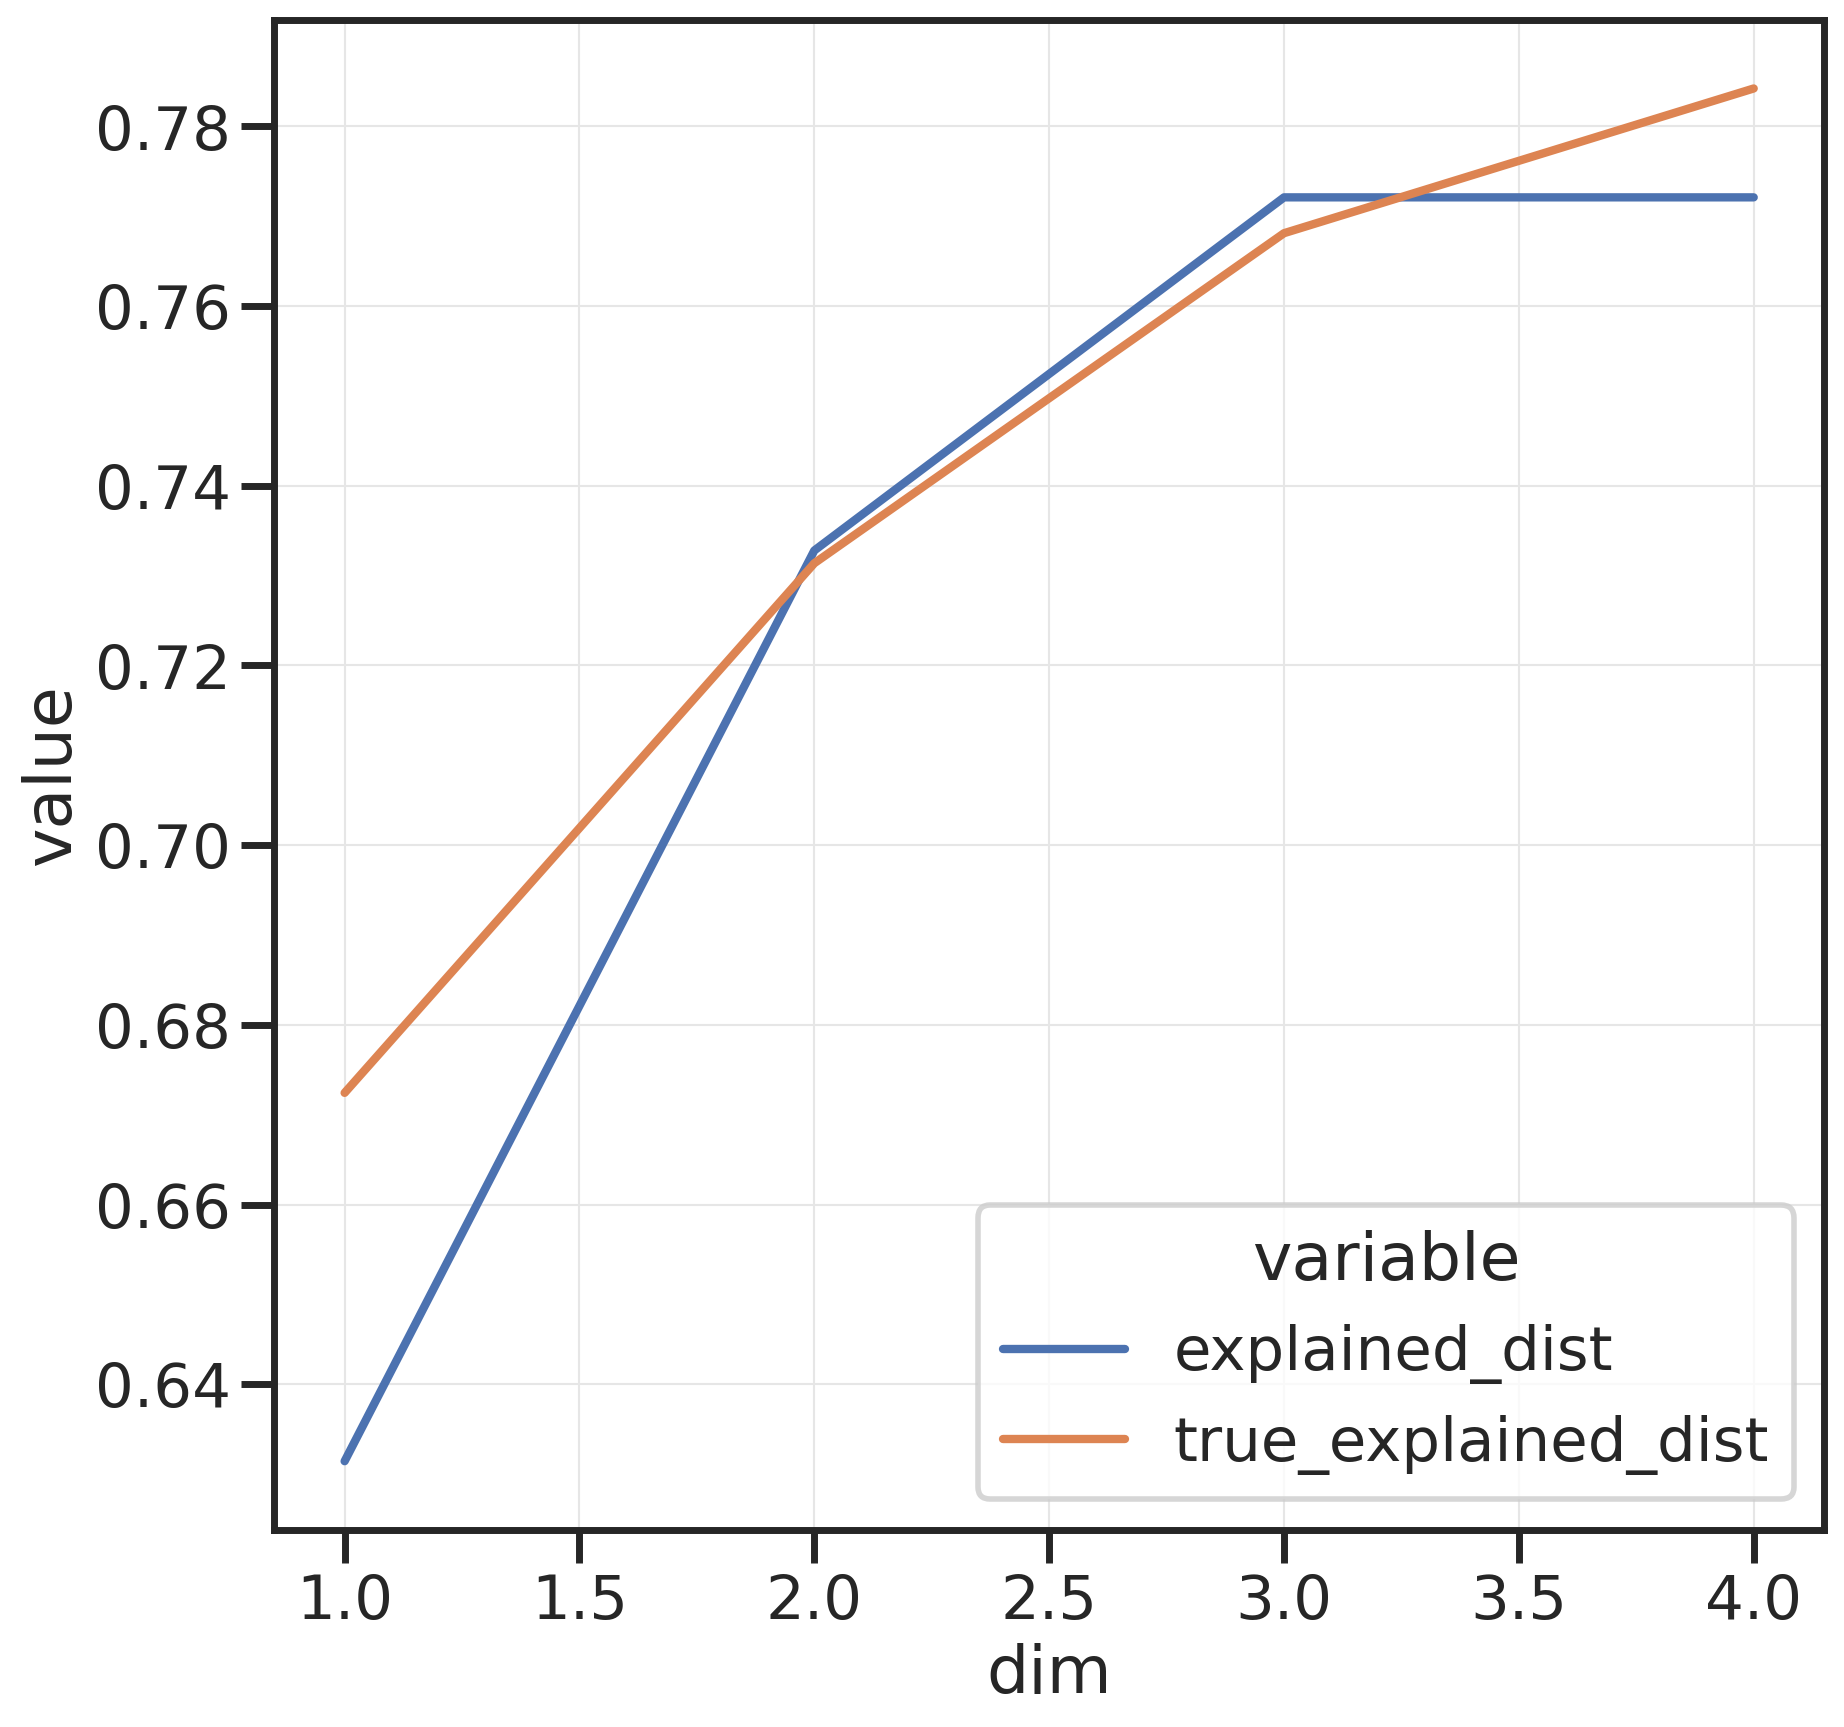

In [69]:
df = pd.DataFrame(th.load('/home/ubuntu/ext_vol/inpca/notebooks/rel_err_sgd_four_pts_avg_0.3_0.7_0_0.p'))
df = df.melt(id_vars=['dim'],value_vars=['explained_dist', 'true_explained_dist'])
sns.lineplot(data=df, x='dim', y='value', hue='variable')

### Matching two embeddings

In [50]:
rtrue = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_no_outliers.p')

In [51]:
rtangent = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/tangents/r_tangent_four_pts_avg_0.2_0.8_0_0.p')

In [30]:
xp = rtangent['xp'][:, :3]

In [31]:
xp[:4, :]

array([[-0.48073369,  0.11529256,  0.01027168],
       [ 0.57326164,  0.06915027, -0.0241348 ],
       [-0.24606544, -0.11036634, -0.04165383],
       [ 0.15353749, -0.0740765 ,  0.05551695]])

In [20]:
x = rtangent['xp'][4:, :3]
y = rtrue['xp'][:, :3]
xmean, ymean = x.mean(0), y.mean(0)
x -= xmean
y -= ymean 

In [21]:
h = x.T @ y

In [22]:
from scipy.linalg import sqrtm
u = h@np.linalg.inv(sqrtm(h.T@h))

In [23]:
x = rtangent['xp'][:, :3]
x -= xmean
x_rot = x@u
rtangent['xp'] = x_rot

In [49]:
U, S, V = np.linalg.svd(h)
d = np.eye(3)
d[-1, -1] = -1
r = V.T @ d @ U.T
x_rot = x@r

In [10]:
np.sqrt(((x_rot - y)**2).sum(-1)).mean()

0.06382258886250015

In [53]:
didx = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_no_outliers.p')
# dpts = pd.DataFrame(['p0', 'ps', 'init', 'end'], columns=['m'])
dpts = pd.DataFrame(['p0', 'ps'], columns=['m'])
didx = pd.concat([didx, dpts]).reset_index(drop=True)

In [58]:
emph={'p0':[149944], 'p1':[149945]}
emphcolor={o:'black' for o in emph.keys()}
emphsize={o:8 for o in emph.keys()}

In [56]:
cdict = CDICT_M
cdict.update({'p0': '#053061', 'ps': '#2166ac', 'init': '#4393c3', 'end': '#92c5de'})

In [46]:
x_rot = (rtangent['xp'][:, :3] - xmean)@u
rtangent['xp'] = x_rot

In [ ]:
plotly_3d(didx, rtangent, color='m', 
          cols=['m'], discrete_c=True, 
          cdict=cdict,
          emph=emph,
          empcolor=emphcolor,
          empsize=emphsize,
#           xrange=[-1.5,1], yrange=[-1.5,0.5], zrange=[-3, 0.5],
          opacity=1,color_axis=True)

In [ ]:
plotly_3d(didx.reset_index(drop=True), rtrue, color='m', 
          cols=['m'], discrete_c=True, 
            cdict=cdict,
          emph=emph,
          empcolor=emphcolor,
          empsize=emphsize,
#           xrange=[-1.5,1], yrange=[-1.5,0.5], zrange=[-3, 0.5],
          opacity=1,color_axis=True)

In [121]:
rtrue['fn'] = np.sqrt(rtrue['fn'])

In [132]:
from utils import explained_stress
explained_distance(rtrue)

[1.0,
 0.4128803912032716,
 0.36098629672036336,
 0.32563701989168237,
 0.29798652498665434,
 0.27456771656766643,
 0.2550066002737695,
 0.2412086873632021,
 0.2286477161451,
 0.21742717472853335,
 0.20808063516408853,
 0.19988062942048293,
 0.19251995276028375,
 0.18662424128981073,
 0.18171746526466673,
 0.1767450898519136,
 0.17826834710206682,
 0.17497254308064467,
 0.17275703645432688,
 0.17042252011932923,
 0.16837925116858435,
 0.16763467125652404,
 0.1662587144011268,
 0.1650086188987617,
 0.16381737607265187,
 0.163050282837098,
 0.16223543667829993,
 0.16147277379746783,
 0.16074627732358926,
 0.1601669133083722,
 0.15970855138303605,
 0.15943542289424495,
 0.1590312004791214,
 0.158796471887349,
 0.15854497365782072,
 0.15835799219325,
 0.15802957220666494,
 0.15773758267107227,
 0.15768528224529077,
 0.15757337976792407,
 0.15725799451721728,
 0.15749812090594922,
 0.1575884619559733,
 0.15748358821641503,
 0.1573290143973384,
 0.1570540649091613,
 0.15676306400042087,
 0.1

In [141]:
r = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p')
r['fn'] = np.sqrt(r['fn'])
explained_distance(r)

[1.0,
 0.49294413287556216,
 3.3595701127200157,
 3.278509377948909,
 3.6964592630337156,
 3.3415955810092006,
 2.9552343502213487,
 2.645291411903231,
 2.259722179937205,
 1.987466819672721,
 1.674304208250198,
 1.5523462251086546,
 1.2993755864833956,
 1.0484705555560823,
 0.9457131364138488,
 0.7706387357017773,
 0.8167085813461145,
 0.8806938342749029,
 0.9312770392033085,
 0.9755884786235262,
 1.0247398246414194,
 0.9768642543492522,
 1.0167358711798313,
 1.0534994624032439,
 0.964492986497826,
 0.9945609037483859,
 1.016896734388502,
 0.9235481361958731,
 0.9323485928507894,
 0.8247986333640701,
 0.8276364679459012,
 0.7744782969223262,
 0.7132555379907037,
 0.6757480339921212,
 0.6248653847525237,
 0.5868893278245645,
 0.5929662350826757,
 0.5467567657652883,
 0.5165529805420476,
 0.5258464696027361,
 0.5405192886310972,
 0.5186293728823159,
 0.539876337292828,
 0.5455522642257876,
 0.5230401439594414,
 0.5281381961945288,
 0.5064466889646531,
 0.5180468702796429,
 0.47131908826

In [138]:
r = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p')

In [140]:
np.sqrt(r['fn'])

24108.09

In [4]:
d1 = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p')

In [5]:
d2 = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/euclidean/didx_all_euclid.p')

In [6]:
d1 = d1.astype(str)
d2 = d2.astype(str)

In [10]:
cols = ['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']
configs =(d2.groupby(cols, sort=False).indices.keys())

In [11]:
from itertools import combinations
ccs = list(combinations(configs,2 )) + [(c, c) for c in configs]

In [12]:
len(ccs)

2639253

In [13]:
f1 = '/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all_geod.h5'
# f2 = '/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yvh_all_geod.h5'
f2 = '/home/ubuntu/ext_vol/inpca/inpca_results_all/euclidean/w_yh_all_euclid.h5'
s12 = 0
s1=0
s2=0
ss1=0
ss2=0
n = 0

ii1 = d1.groupby(cols, sort=False).indices
ii2 = d2.groupby(cols, sort=False).indices
for (c1, c2) in tqdm.tqdm(ccs):
    i11, i12 = ii1[c1], ii1[c2]
    i21, i22 = ii2[c1], ii2[c2]
    with h5py.File(f1, 'r') as f:
        w1 = f['w'][i11.min():i11.max()+1, i12.min():i12.max()+1]
    with h5py.File(f2, 'r') as f:
        w2 = f['w'][i21.min():i21.max()+1, i22.min():i22.max()+1]
    s12 += (w1*w2).sum()
    s1 += w1.sum()
    s2 += w2.sum()
    ss1 += (w1**2).sum()
    ss2 += (w2**2).sum()
    n += np.prod(w1.shape)

100%|████████████████████████████████| 2639253/2639253 [44:48<00:00, 981.82it/s]


In [14]:
N = n**2
corr = ((N*s12) - s1*s2)/(np.sqrt(N*ss1 - s1**2)*np.sqrt(N*ss2 - s2**2))

In [15]:
corr

0.7946174349185249

In [16]:
stats = {
    's12':s12, 's1':s1, 's2':s2, 'ss1':ss1, 'ss2':ss2, 'n':n, 'corr':corr
}
th.save(stats, 'stats.p')

In [20]:
1-(ss1+ss2-2*s12) / ss1

0.6210068454414901

In [48]:
N = n**2
s12=s12.sum()
corr = ((N*s12) - s1*s2)/(np.sqrt(N*ss1 - s1**2)*np.sqrt(N*ss2 - s2**2))

In [54]:
r = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p')

In [55]:
n = r['xp'].shape[0]

In [57]:
dd = dinpca(th.tensor(r['xp'][:20, :i]),
    th.tensor(r['xp'][:30, :i]),
    dev='cuda',
    sign=th.tensor(np.sign(r['e'][:i])).double()).cpu().numpy()